In [218]:
# Import required libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

### Summary

My approach was to select features with the highest importance score, and select hyperparameters (min samples in leaf and max depth) that gave the highest R-squared and accuracy score, respectively.

### Part 1: Predicting the total number of vomiting episodes without using vomiting or nausea as a predictor.

In [219]:
df = pd.read_csv('../data/Copy of CINV Final Raw Data_ADI2024.xlsx - Variable View.csv')

In [220]:
df.columns

Index(['Patient_Code', 'Gender', 'Age', 'Weight', 'Height', 'BMI', 'BSA',
       'Marital_Status', 'Religion', 'County_of_Residence', 'Smoking_Status',
       'Drinking_Status', 'Last_Meal_Before_Chemotherapy',
       'Stage_of_Breast_Cancer', 'Duration_of_Illness', 'Children',
       'Morning_Sickness_During_Pregnancy', 'Comorbidities', 'Cycle',
       'Chemotherapy_Regimen', 'Chemotherapy_Frequency', 'Ondansetron',
       'Dexamethasone', 'Granisetron', 'Oral_Dexamethasone',
       'Metoclopramide_10mg_TDS_PO', 'Metoclopramide_10mg_IV', 'Palonosetron',
       'Other_Antiemetics', 'CINV_Route', 'CINV_Frequency',
       'CINV_Time_of_Administration', 'Anticipatory_Vomiting',
       'Nausea_within_24_hours_post_Chemotherapy',
       'Scale_of_Nausea_0_to_24_hours_post_Chemotherapy',
       'Vomiting_0to12_hours_post_Chemotherapy',
       'Number_of_Vomiting_Episodes_0to12_hours_post_Chemotherapy',
       'Vomiting_13to24_hours_post_Chemotherapy',
       'Number_of_Vomiting_Episodes_13to

In [221]:
df

,Patient_Code,Gender,Age,Weight,Height,BMI,BSA,Marital_Status,Religion,County_of_Residence,...,Day_3_Vomiting,Number_of_Day_3_Vomiting_Episodes,Day_4_Nausea,Scale_of_Day_4_Nausea,Day_4_Vomiting,Number_of_Day_4_Vomiting_Episodes,Day_5_Nausea,Scale_of_Day_5_Nausea,Day_5_Vomiting,Number_of_Day_5_Vomiting_Episodes
0,200,Female,45,52,1.62,19.81,1.530,Married,Christian,Nairobi,...,No,0,Yes,3,No,0,Yes,1,No,0
1,300,Female,32,56,1.62,21.15,1.680,Single,Christian,Nairobi,...,No,0,No,0,No,0,Yes,7,Yes,1
2,500,Female,46,88,1.61,33.95,1.917,Divorced,Christian,Kiambu,...,No,0,No,0,No,0,No,0,No,0
3,600,Female,41,54,1.55,22.48,1.606,Married,Christian,Nairobi,...,No,0,No,0,No,0,No,0,No,0
4,800,Female,37,45,1.50,20.00,1.369,Married,Christian,Kiambu,...,No,0,No,0,No,0,No,0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,10900,Female,37,48,1.54,20.24,1.410,Single,Christian,Muranga,...,No,0,No,0,No,0,No,0,No,0
106,11000,Female,68,62,1.68,21.97,1.650,Married,Christian,Muranga,...,No,0,No,0,No,0,No,0,No,0
107,11100,Female,58,56,1.52,24.24,1.670,Married,Christian,Kiambu,...,No,0,No,0,No,0,No,0,No,0
108,11200,Female,33,56,1.62,21.34,1.680,Single,Christian,Nairobi,...,No,0,Yes,6,No,0,Yes,5,Yes,1


In [222]:
    # Calculate sum of vomiting episodes for days 1-5
    columns_to_sum = [
        'Number_of_Vomiting_Episodes_0to12_hours_post_Chemotherapy',
        'Number_of_Vomiting_Episodes_13to24_hours_post_Chemotherapy',
        'Number_of_Day_2_Vomiting_Episodes',
        'Number_of_Day_3_Vomiting_Episodes',
        'Number_of_Day_4_Vomiting_Episodes',
        'Number_of_Day_5_Vomiting_Episodes'
    ]
    df['Number_of_Vomiting_Episodes_Within_5_Days'] = df[columns_to_sum].sum(axis=1)

In [223]:
# Define columns to keep
features_to_keep = [
    # Patient Demographics
    'Gender', 'Age', 'Weight', 'Height', 'BMI', 'BSA', 'Marital_Status',
    'Religion', 'County_of_Residence', 'Children',
    
    # Risk Factors
    'Smoking_Status', 'Drinking_Status', 'Last_Meal_Before_Chemotherapy',
    'Morning_Sickness_During_Pregnancy',
    
    # Disease Characteristics
    'Stage_of_Breast_Cancer', 'Duration_of_Illness', 'Comorbidities',
    
    # Treatment Details
    'Cycle', 'Chemotherapy_Regimen', 'Chemotherapy_Frequency',
    
    # Antiemetic Medications
    'Ondansetron', 'Dexamethasone', 'Granisetron', 'Oral_Dexamethasone',
    'Metoclopramide_10mg_TDS_PO', 'Metoclopramide_10mg_IV', 'Palonosetron',
    'Other_Antiemetics',
    
    # CINV Administration Details
    'CINV_Route', 'CINV_Frequency', 'CINV_Time_of_Administration',
]

early_symptom_features = [
    # Early Symptoms
    'Anticipatory_Vomiting', 'Nausea_within_24_hours_post_Chemotherapy',
    'Scale_of_Nausea_0_to_24_hours_post_Chemotherapy',
    'Vomiting_0to12_hours_post_Chemotherapy',
    'Number_of_Vomiting_Episodes_0to12_hours_post_Chemotherapy',
    'Vomiting_13to24_hours_post_Chemotherapy',
    'Number_of_Vomiting_Episodes_13to24_hours_post_Chemotherapy'
]

# Target variable
target = 'Number_of_Vomiting_Episodes_Within_5_Days'

# Create initial feature matrix
X = df[features_to_keep].copy()
y = df[target].copy()

# Process categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X.loc[:, column] = LabelEncoder().fit_transform(X[column].fillna('missing'))

# Process numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    X.loc[:, column] = X[column].fillna(X[column].median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Select features using SelectFromModel
selector = SelectFromModel(rf, prefit=True, threshold='mean')
feature_mask = selector.get_support()
selected_features = X_train.columns[feature_mask].tolist()

# Apply feature selection to both train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Print results
print("Initial number of features:", len(features_to_keep))
print("\nTop 20 Most Important Features:")
print(importance.head(20).to_string(index=False))

print("\nSelected Features Summary:")
print(f"Number of features selected: {len(selected_features)}")
print(f"Original number of features: {len(X.columns)}")

print("\nSelected Features:")
for i, feature in enumerate(selected_features, 1):
    importance_value = importance[importance['feature'] == feature]['importance'].values[0]
    print(f"{i}. {feature}: {importance_value:.4f}")

print("\nDataset Shapes:")
print(f"X_train_selected: {X_train_selected.shape}")
print(f"X_test_selected: {X_test_selected.shape}")

Initial number of features: 31

Top 20 Most Important Features:
                          feature  importance
                            Cycle    0.363098
                      Ondansetron    0.093121
                           Height    0.085173
                              Age    0.063484
                              BMI    0.059487
                    Comorbidities    0.053858
                           Weight    0.044229
                Other_Antiemetics    0.040653
                              BSA    0.037169
              Duration_of_Illness    0.028964
              County_of_Residence    0.026620
                   Marital_Status    0.023938
           Stage_of_Breast_Cancer    0.020069
                  Drinking_Status    0.013117
                         Children    0.009570
    Last_Meal_Before_Chemotherapy    0.008547
             Chemotherapy_Regimen    0.007376
                    Dexamethasone    0.005768
Morning_Sickness_During_Pregnancy    0.005558
                

Best parameters:
Max depth: 4
Min samples leaf: 6
Test R² score: 0.319


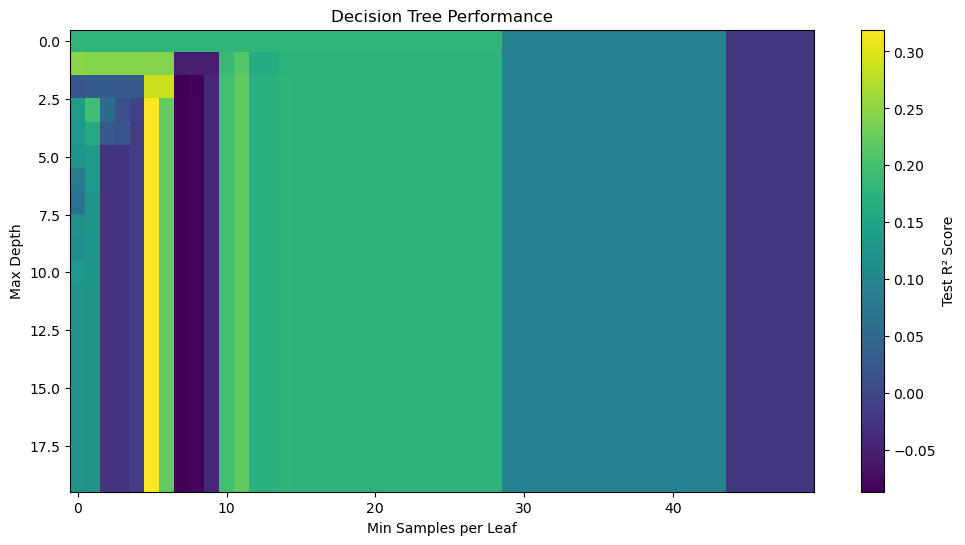

In [224]:
# Parameter grids
max_depths = range(1, 21)
min_samples = range(1, 51)

# Store results
results = []

# Grid search
for depth in max_depths:
    for samples in min_samples:
        dt = DecisionTreeRegressor(max_depth=depth, 
                                 min_samples_leaf=samples, 
                                 random_state=42)
        dt.fit(X_train, y_train)
        test_score = dt.score(X_test, y_test)
        results.append((depth, samples, test_score))

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'test_r2'])
best_params = results_df.loc[results_df['test_r2'].idxmax()]

best_max_depth = int(best_params['max_depth'])
best_min_samples = int(best_params['min_samples_leaf'])

print(f"Best parameters:")
print(f"Max depth: {best_max_depth}")
print(f"Min samples leaf: {best_min_samples}")
print(f"Test R² score: {best_params['test_r2']:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
pivot_table = results_df.pivot(index='max_depth', 
                             columns='min_samples_leaf', 
                             values='test_r2')
plt.imshow(pivot_table, aspect='auto')
plt.colorbar(label='Test R² Score')
plt.xlabel('Min Samples per Leaf')
plt.ylabel('Max Depth')
plt.title('Decision Tree Performance')
plt.show()

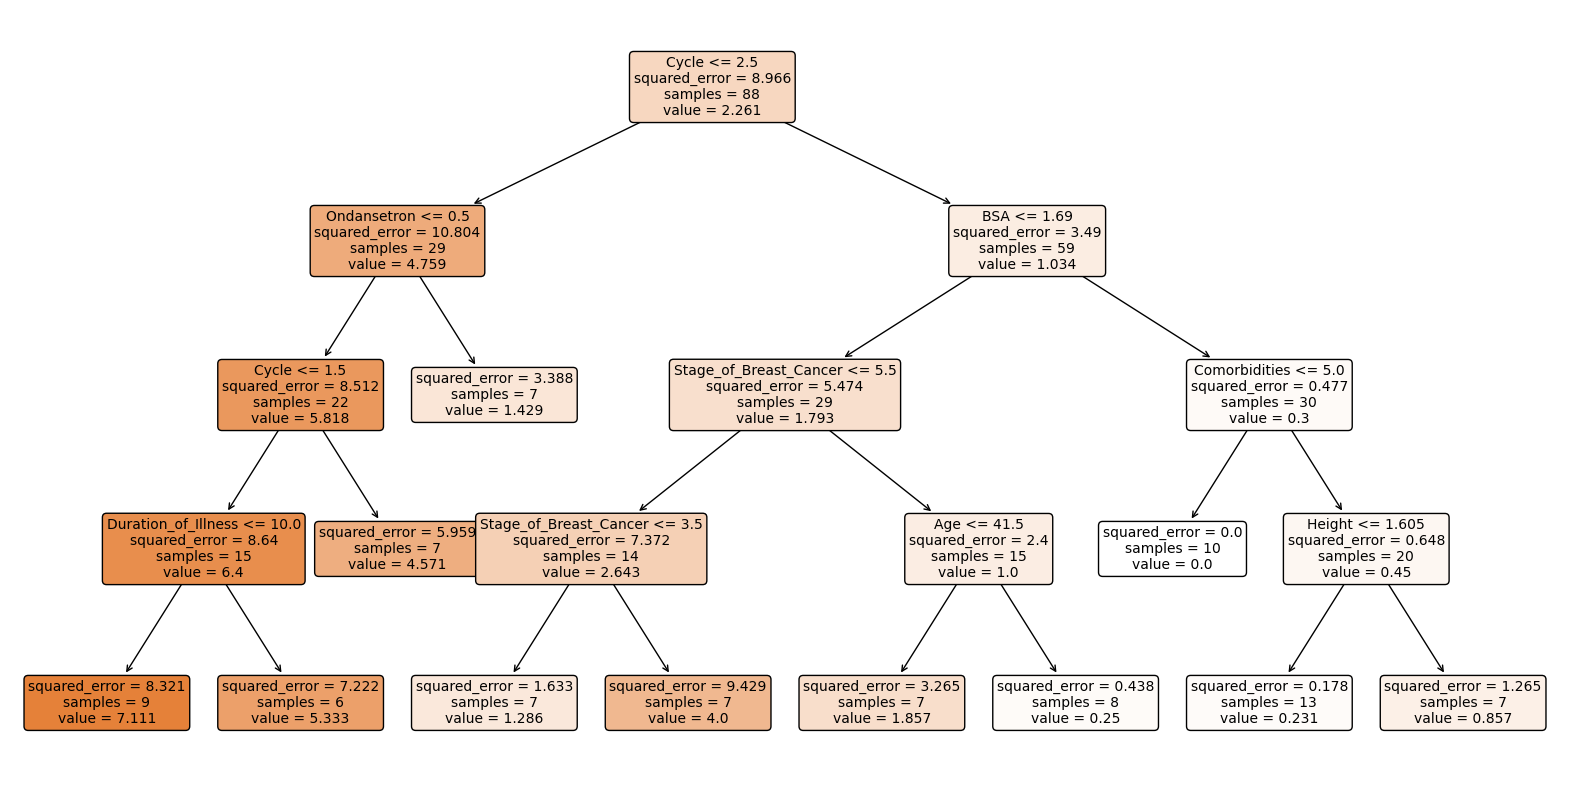

Training R² Score: 0.622
Testing R² Score: 0.319


In [225]:
# Create and train the model
dt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples, random_state=42)
dt.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dt, 
          feature_names=list(X_train.columns),
          filled=True, 
          rounded=True,
          fontsize=10)
plt.show()

# Print model performance
train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
print(f"Training R² Score: {train_score:.3f}")
print(f"Testing R² Score: {test_score:.3f}")

### Part 2: Predicting Nausea within 5 days.

In [226]:
target_2 = 'Nausea_within_5_days'
columns = [
   'Nausea_within_24_hours_post_Chemotherapy',
   'Day_2_Nausea',
   'Day_3_Nausea', 
   'Day_4_Nausea',
   'Day_5_Nausea'
]

df[target_2] = (df[columns] == 'Yes').any(axis=1).map({True: 'Yes', False: 'No'})
df[columns + [target_2]]

,Nausea_within_24_hours_post_Chemotherapy,Day_2_Nausea,Day_3_Nausea,Day_4_Nausea,Day_5_Nausea,Nausea_within_5_days
0,Yes,Yes,Yes,Yes,Yes,Yes
1,Yes,Yes,Yes,No,Yes,Yes
2,Yes,No,No,No,No,Yes
3,Yes,Yes,No,No,No,Yes
4,Yes,No,No,No,No,Yes
...,...,...,...,...,...,...
105,No,No,No,No,No,No
106,No,No,No,No,No,No
107,Yes,Yes,Yes,No,No,Yes
108,Yes,Yes,Yes,Yes,Yes,Yes


In [227]:
print(df[target_2].value_counts())
print('\nPercentage:')
print(df[target_2].value_counts(normalize=True))

Nausea_within_5_days
Yes    81
No     29
Name: count, dtype: int64

Percentage:
Nausea_within_5_days
Yes    0.736364
No     0.263636
Name: proportion, dtype: float64


In [228]:
# Part 2
# Define columns to keep
features_to_keep = [
   # Patient Demographics
   'Gender', 'Age', 'Weight', 'Height', 'BMI', 'BSA', 'Marital_Status',
   'Religion', 'County_of_Residence', 'Children',
   
   # Risk Factors 
   'Smoking_Status', 'Drinking_Status', 'Last_Meal_Before_Chemotherapy',
   'Morning_Sickness_During_Pregnancy',
   
   # Disease Characteristics
   'Stage_of_Breast_Cancer', 'Duration_of_Illness', 'Comorbidities',
   
   # Treatment Details
   'Cycle', 'Chemotherapy_Regimen', 'Chemotherapy_Frequency',
   
   # Antiemetic Medications
   'Ondansetron', 'Dexamethasone', 'Granisetron', 'Oral_Dexamethasone', 
   'Metoclopramide_10mg_TDS_PO', 'Metoclopramide_10mg_IV', 'Palonosetron',
   'Other_Antiemetics',
   
   # CINV Administration Details
   'CINV_Route', 'CINV_Frequency', 'CINV_Time_of_Administration',
]

early_symptom_features = [
   # Early Symptoms
   'Anticipatory_Vomiting',
   'Scale_of_Nausea_0_to_24_hours_post_Chemotherapy',
   'Vomiting_0to12_hours_post_Chemotherapy',
   'Number_of_Vomiting_Episodes_0to12_hours_post_Chemotherapy',
   'Vomiting_13to24_hours_post_Chemotherapy', 
   'Number_of_Vomiting_Episodes_13to24_hours_post_Chemotherapy'
]

# Create initial feature matrix
X = df[features_to_keep].copy()
y = (df[target_2] == 'Yes').astype(int)  # Convert Yes/No to 1/0

# Process categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
   X.loc[:, column] = LabelEncoder().fit_transform(X[column].fillna('missing'))

# Process numerical columns  
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
   X.loc[:, column] = X[column].fillna(X[column].median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Random Forest
dt = DecisionTreeClassifier(random_state=42) 
dt.fit(X_train, y_train)

# Get feature importance
importance = pd.DataFrame({
   'feature': X_train.columns,
   'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

# Select features using SelectFromModel
selector = SelectFromModel(dt, prefit=True, threshold='mean')
feature_mask = selector.get_support()
selected_features = X_train.columns[feature_mask].tolist()

# Apply feature selection to both train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Print results
print("Initial number of features:", len(features_to_keep))
print("\nTop 20 Most Important Features:")
print(importance.head(20).to_string(index=False))
print("\nSelected Features Summary:")
print(f"Number of features selected: {len(selected_features)}")
print(f"Original number of features: {len(X.columns)}")
print("\nSelected Features:")
for i, feature in enumerate(selected_features, 1):
   importance_value = importance[importance['feature'] == feature]['importance'].values[0]
   print(f"{i}. {feature}: {importance_value:.4f}")
print("\nDataset Shapes:")
print(f"X_train_selected: {X_train_selected.shape}")
print(f"X_test_selected: {X_test_selected.shape}")

Initial number of features: 31

Top 20 Most Important Features:
                   feature  importance
                     Cycle    0.291340
                       BSA    0.216224
                       BMI    0.161350
            Marital_Status    0.105661
       Duration_of_Illness    0.066788
       County_of_Residence    0.061445
                    Height    0.042744
            Smoking_Status    0.041443
           Drinking_Status    0.008905
             Comorbidities    0.004100
                CINV_Route    0.000000
         Other_Antiemetics    0.000000
               Ondansetron    0.000000
              Palonosetron    0.000000
    Metoclopramide_10mg_IV    0.000000
Metoclopramide_10mg_TDS_PO    0.000000
        Oral_Dexamethasone    0.000000
            CINV_Frequency    0.000000
               Granisetron    0.000000
             Dexamethasone    0.000000

Selected Features Summary:
Number of features selected: 8
Original number of features: 31

Selected Features:
1. Hei

Best parameters:
Max depth: 3
Min samples leaf: 11
Test accuracy: 0.818


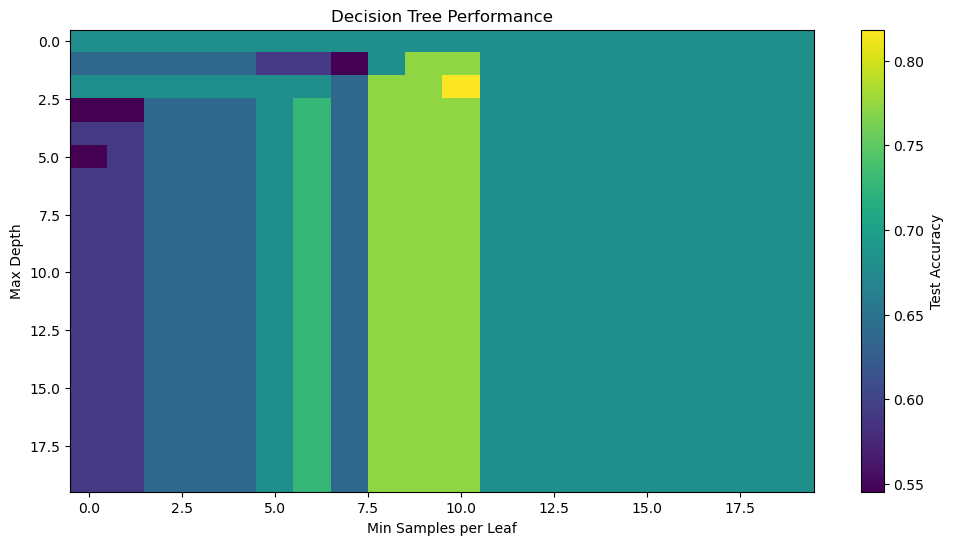

In [229]:
from sklearn.metrics import accuracy_score

# Parameter grids
max_depths = range(1, 21)
min_samples = range(1, 21)
# Store results
results = []

# Grid search with accuracy metric instead of R2
for depth in max_depths:
   for samples in min_samples:
       dt = DecisionTreeClassifier(max_depth=depth, 
                                 min_samples_leaf=samples, 
                                 random_state=42)
       dt.fit(X_train, y_train)
       test_score = accuracy_score(y_test, dt.predict(X_test))
       results.append((depth, samples, test_score))

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'test_accuracy'])
best_params = results_df.loc[results_df['test_accuracy'].idxmax()]
best_max_depth = int(best_params['max_depth'])
best_min_samples = int(best_params['min_samples_leaf'])

print(f"Best parameters:")
print(f"Max depth: {best_max_depth}")
print(f"Min samples leaf: {best_min_samples}")
print(f"Test accuracy: {best_params['test_accuracy']:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
pivot_table = results_df.pivot(index='max_depth', 
                             columns='min_samples_leaf', 
                             values='test_accuracy')
plt.imshow(pivot_table, aspect='auto')
plt.colorbar(label='Test Accuracy')
plt.xlabel('Min Samples per Leaf')
plt.ylabel('Max Depth')
plt.title('Decision Tree Performance')
plt.show()

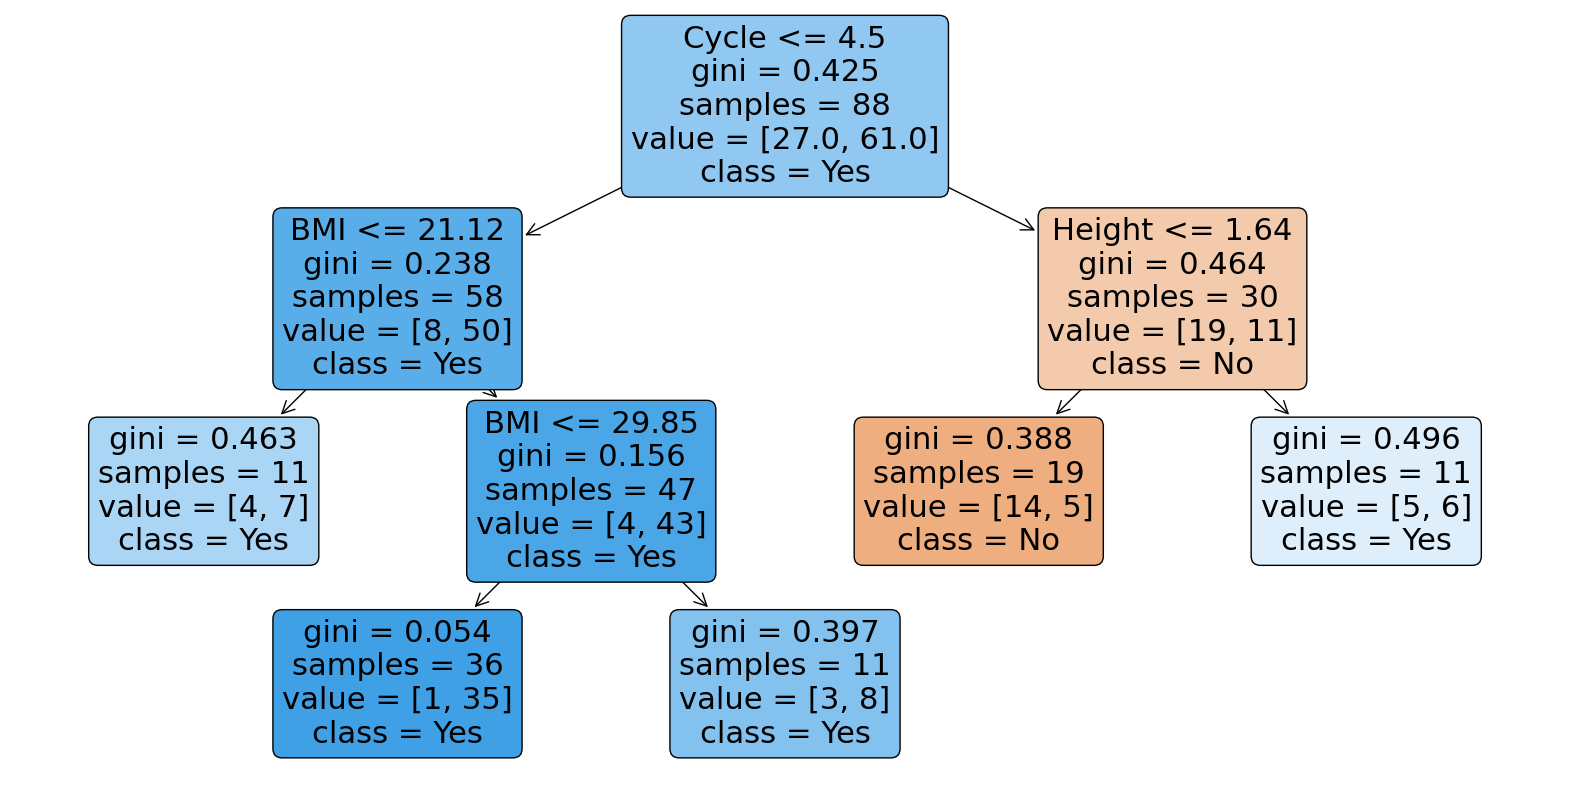

Train accuracy: 0.795
Test accuracy: 0.818


In [231]:
# Train final decision tree with optimal parameters
final_dt = DecisionTreeClassifier(
  max_depth=best_max_depth,
  min_samples_leaf=best_min_samples,
  random_state=42
)
final_dt.fit(X_train_selected, y_train)

# Evaluate
y_pred_train = final_dt.predict(X_train_selected)
y_pred_test = final_dt.predict(X_test_selected)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Visualize tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(final_dt, 
       feature_names=selected_features,
       class_names=['No', 'Yes'],
       filled=True,
       rounded=True)
plt.show()

print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")